In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import time
import json
from glob import glob
from PIL import Image

import tensorflow as tf
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as rn_preprocess
import os
import pickle

Using TensorFlow backend.


In [2]:
folder = "../input/pictest/"
images = os.listdir(folder)
inc_model = InceptionV3(weights='imagenet')
inc_model_new = tf.keras.Model(inc_model.input, inc_model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [3]:
rn_model = ResNet50(weights='imagenet')
rn_model_new = tf.keras.Model(rn_model.input, rn_model.layers[-2].output)

102973440/102967424 [==============================] - 1s 0us/step


In [4]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2048, activation=tf.nn.softmax)])

In [5]:
images_new = os.listdir("../input/pictest/")

img_features_rn = dict()
img_features_cnn = dict()
img_features_inc = dict()

for img in images_new:
    img_rn = image.load_img("../input/pictest/" + img, target_size=(224, 224))
    x_rn = image.img_to_array(img_rn)
    x_rn = np.expand_dims(x_rn, axis=0)
    x_rn = rn_preprocess(x_rn)
    fea_x_rn = rn_model_new.predict(x_rn)
    fea_x1_rn = np.reshape(fea_x_rn , fea_x_rn.shape[1])
    img_features_rn[img] = fea_x1_rn
    
    img_inc = image.load_img("../input/pictest/" + img, target_size=(299, 299))
    x_inc = image.img_to_array(img_inc)
    x_inc = np.expand_dims(x_inc, axis=0)
    x_inc = inc_preprocess(x_inc)  
    fea_x_inc = inc_model_new.predict(x_inc)
    fea_x1_inc = np.reshape(fea_x_inc , fea_x_inc.shape[1])
    img_features_inc[img] = fea_x1_inc
    
    img_cnn = image.load_img("../input/pictest/" + img, target_size=(224, 224, 3))
    x_cnn = image.img_to_array(img_cnn)
    x_cnn = np.expand_dims(x_cnn, axis=0)
    fea_x_cnn = cnn_model.predict(x_cnn).reshape(2048)
    img_features_cnn[img] = fea_x_cnn
    
#print("--- %s seconds for feature extraction ---" % (time.time() - start_time))


In [6]:
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

In [7]:
model_rn50 = load_model('../input/model-final/model_rn50_glove.h5')
model_inc = load_model('../input/model-final/model_inc_glove.h5')
model_cnn = load_model('../input/model-final/model_cnn_no_glove.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [8]:
#Read Word Index
infile = open("../input/flickr8k-captions/word_index.pkl",'rb')
word_index = pickle.load(infile)
infile.close()

infile = open("../input/flickr8k-captions/index_word.pkl",'rb')
index_word = pickle.load(infile)
infile.close()

In [9]:
def createCaption(photo, model, max_length = 34):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[w] for w in in_text.split() if w in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    return ' '.join(final)

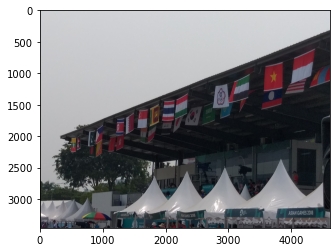

RN50:  people are standing in a large red tent
Inc:  man in a black jacket is standing in a city area
CNN:  man in a red shirt and a black shirt is standing on a rock


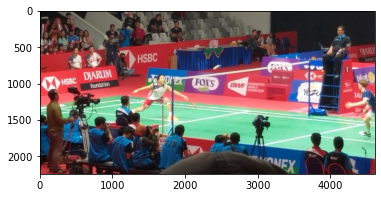

RN50:  people are playing a game of hockey
Inc:  men are playing on a baseball court
CNN:  man in a red shirt and a woman in a red shirt and a white shirt


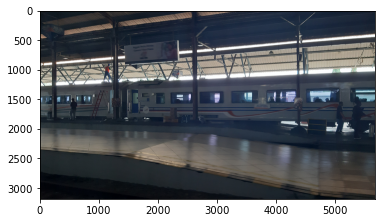

RN50:  are playing instruments in a stadium
Inc:  man in a red shirt is looking at a bus
CNN:  man in a red shirt and a woman in a red shirt and a white shirt


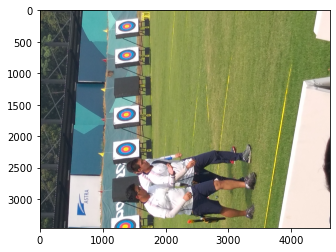

RN50:  little boy in a red shirt is playing with a ball in a park
Inc:  man in a blue shirt is sitting on a skateboard
CNN:  man in a red shirt and a woman in a red shirt and black shorts


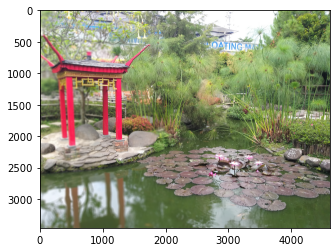

RN50:  boy in a red shirt is walking down a stream
Inc:  little girl is sitting on a rock stump
CNN:  man in a red shirt and a woman in a red shirt and a white shirt


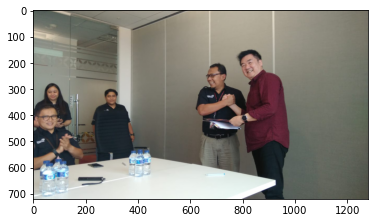

RN50:  group of people are sitting in a white room
Inc:  women are posing for a picture
CNN:  man in a red shirt and a woman in a red shirt and a white shirt


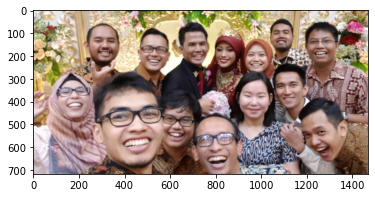

RN50:  group of people are posing for the camera
Inc:  group of people are posing for a picture
CNN:  man in a red shirt and a woman in a red shirt and black shorts


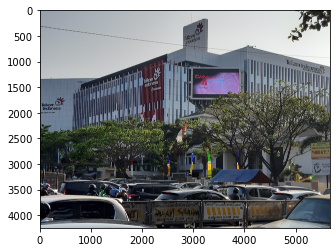

RN50:  people are in the air with a white umbrella in front of a building
Inc:  people are standing in the street with their flags in the city
CNN:  man in a red shirt and a woman in a red shirt and a white shirt


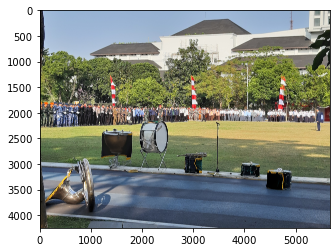

RN50:  people are sitting on a motorcycle
Inc:  man is standing on the beach near a crowd of people
CNN:  man in a red shirt and a woman in a red shirt and a white shirt


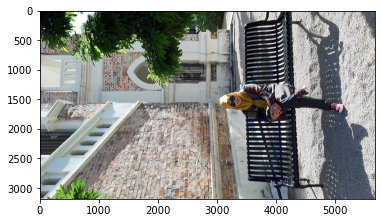

RN50:  people are sitting in a fountain
Inc:  woman sits on a bench in a doorway
CNN:  man in a red shirt and a woman in a red shirt and black shorts


In [10]:
preds = dict()
for p in img_features_cnn.keys():
    
    x=plt.imread("../input/pictest/" + p)
    plt.imshow(x)
    plt.show()
    
    sample_fea_cnn = img_features_cnn[p]
    sample_fea_rn = img_features_rn[p]
    sample_fea_inc = img_features_inc[p]

    caption_rn = createCaption((sample_fea_rn).reshape((1,2048)), model_rn50)
    caption_inc = createCaption((sample_fea_inc).reshape((1,2048)), model_inc)
    caption_cnn = createCaption((sample_fea_cnn).reshape((1,2048)), model_cnn)
    
    print("RN50: ", caption_rn)
    print("Inc: ", caption_inc)
    print("CNN: ", caption_cnn)
    #preds[p] = a
    